In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.matlib import repmat
import pandas as pd

path = r'C:\Users\zzsgdsg7\Desktop\2021年B题\附件1 监测点A空气质量预报基础数据.xlsx'

data = pd.read_excel(path,sheet_name=1)
data.iloc[:,0] = pd.to_datetime(data.iloc[:,0])
data.set_axis(['time', 'place', 'so2','no2','pm10', 'pm2.5', 'o3','co','temperature', 'humidity', 'pressure','wind','direction'], axis='columns',inplace=True)
#print(data.head())

#数据基本处理
modeltime = data['time']
data = data.drop(columns=['place','time'])
data= data.replace('—', np.nan)
data = data.astype('float')
data[ data< 0 ] = np.nan
print(data.head())
data.insert(0,'time',modeltime)#重新插入时间列

#KNN插值

data_knn =data

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):#判断值是否是空
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

for indexs in data.columns:
    if indexs =='time':
        continue
    data_knn[indexs] = knn_mean(data_knn[indexs].values,24)

   so2   no2  pm10  pm2.5    o3   co  temperature  humidity  pressure  wind  \
0  5.0  75.0  61.0   38.0   1.0  1.0         21.1      89.0    1013.0   1.2   
1  5.0  64.0  60.0   41.0  25.0  0.8         20.4      92.0    1012.4   1.1   
2  4.0  60.0  36.0   40.0  25.0  0.8         20.0      93.0    1011.3   1.1   
3  4.0  39.0  35.0   33.0  41.0  0.7         19.8      93.0    1010.4   1.5   
4  4.0  39.0  28.0   39.0  36.0  0.8         19.9      92.0    1010.0   1.5   

   direction  
0      346.5  
1       18.0  
2       65.9  
3       78.4  
4       73.5  


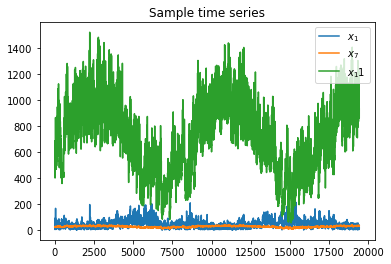

In [54]:
#x1 = data_knn['so2']
#x2 = data_knn['no2']
x1 = data_knn['pm10']
x4 = data_knn['pm2.5']
x5 = data_knn['o3']
x6 = data_knn['co']
x7 = data_knn['temperature']
x8 = data_knn['humidity']
x9 = data_knn['pressure']
x10 = data_knn['wind']

x11 =np.array(x1)+np.array(x7)**2 

#plot
cdata = np.array([x1,x7,x11]).T
plt.plot(cdata)
plt.title('Sample time series')
plt.legend(['$x_1$','$x_7$','$x_11$'])

(19432, 3)

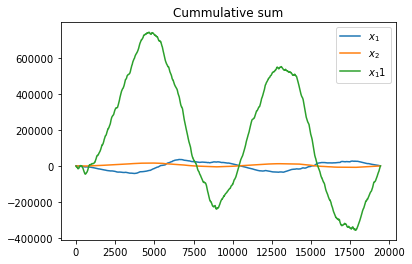

In [55]:
# Define
nsamples,nvars = cdata.shape

# Cummulative sum after removing mean
cdata = cdata-cdata.mean(axis=0)
xx = np.cumsum(cdata,axis=0)
plt.plot(xx)
plt.title('Cummulative sum')
plt.legend(['$x_1$','$x_2$','$x_11$'])
xx.shape

In [56]:
# Return sliding windows
def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    import numpy as np
    # generate indexes. O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx

In [57]:
# Compute Eq.4
k = 24
F2_dfa_x = np.zeros(nvars)
allxdif = []
for ivar in range(nvars): # do for all vars
    xx_swin , idx = sliding_window(xx[:,ivar],k)
    nwin = xx_swin.shape[0]
    b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit
    #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # slow version
    x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    # Store differences to the linear fit
    xdif = xx_swin-x_hatx
    allxdif.append(xdif)
    # Eq.4
    F2_dfa_x[ivar] = (xdif**2).mean()

In [58]:
# Get the DCCA matrix
dcca = np.zeros([nvars,nvars])
for i in range(nvars): # do for all vars
    for j in range(nvars): # do for all vars
        # Eq.5 and 6
        F2_dcca = (allxdif[i]*allxdif[j]).mean()
        # Eq.1: DCCA
        dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])

dcca

array([[1.        , 0.36581467, 0.46137343],
       [0.36581467, 1.        , 0.97217807],
       [0.46137343, 0.97217807, 1.        ]])